--- 
Microeconometrics | Summer 2021 | M.Sc. Economics, Bonn University 

# Replication of Angrist, J., and Evans, W. (1998). "Children and Their Parent's Labor Supply: Evidence from Exogenous Variation in Family Size". <a class="tocSkip">   

[Carolina Alvarez](https://github.com/carolinalvarez)
---

**Angrist, J.D., & Evans, W.N. (1998).** [Children and Their Parents' Labor Supply: Evidence from Exogenous Variation in Family Size](https://www.jstor.org/stable/116844?seq=1). *The American Economic Review*, 88(3). 450-477. 

# Table of contents
* [Introduction](#Introduction)
* [Identification Strategy](#Identification)
* [Empirical Methodology](#Empirical-Methodology)
* [Replication Angrist & Evans (1998)](#Replication-of-Angrist-&-Evans-(1998))
 * [Data & Descriptive Statistics](#Data-&-Descriptive-Statistics)

In [1]:
%matplotlib inline
#!pip install linearmodels
#!pip install stargazer
import numpy as np
import pandas as pd
import pandas.io.formats.style
import seaborn as sns
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm_api
from linearmodels.iv import IV2SLS
import matplotlib as plt
import matplotlib.pyplot as plt
import copy
from IPython.display import HTML
from stargazer.stargazer import Stargazer
from statsmodels.api import add_constant

---
# Introduction 
---

Angrist and Evans (1998) study the causal mechanisms between fertility and the work effort of both men and women. The authors begin by explaining the theoretical and practical reasons of studying the relationship between fertility and labor supply. First, there has been development of economic models that link the family and the labor market. Second, the relationship between fertility and labor supply could explain the increase of women's participation in the labor market in the post-war period, where having fewer children could have increased the female labor-force share. Meanwhile, other studies have linked fertility with female withdraws from the labor market and lower wages compared to men.

The mayority of empirical studies related to childbearing and labor supply find a negative correlation between family size (i.e., fertility) and female labor force. However, in his assesment of Economics of the Family, Robert J. Willis argues that there has not been well-measured exogenous variables that allow to separate cause and effect relationships from correlations among variables such as delay of marriage, decline of childbearing, increase in divorces, and increase in female labor force participation.

In this vein, the authors argue that the problems concerning the causal association between family size and labor supply arises from the theoretical argument that both factors are jointly determinated. For example, some labor-supply econometric models often use child-status variables as regressors on hours of work. On the other hand, economic demographers usually measure the effect of wages on fertility. According to the authors, "*since fertility variables cannot be both dependent and exogenous at the same time, it seems unlikely that either sort of regression has a causal interpretation*". 

Angrist and Evans (1998) contribute by using an **instrumental variable strategy (IV)** based on the sex-mix of children in families with two or more kids. This captures parental preferences for mixed-sex siblings, where parents of same-sex children are much more likely to have an additional child.

**Endogeneity Problem**

<center>Fertility 🠊 Labor supply</center>
<center>Labor supply 🠊 Fertility </center>

**Instrument** 

<center>Dummy variable for whether the sex of the second child matches the sex of the first child</center> 




---
# Identification
--- 
![ERROR:Here should be causal graph 1](files/causal_graph_v1.png)


---
# Empirical Methodology
## Casual estimation with a Binary IV

\begin{equation}
Y = \alpha + \delta D + \epsilon
\end{equation}

\begin{equation}
E[Y] = E[\alpha + \delta D + \epsilon]= \alpha + \delta E[D] + E[\epsilon]
\end{equation}

We re-write it as a difference equation in Z and divide both sides by $ E[D|Z=1] - E[D|Z=0]$ which yields:

\begin{equation}
\frac{E[Y|Z=1]-E[Y|Z=0]}{E[D|Z=1]-E[D|Z=0]} =\frac{\delta (E[D|Z=1]-E[D|Z=0]) + (E[\epsilon|Z=1]-E[\epsilon|Z=0])}{E[D|Z=1]-E[D|Z=0]}
\end{equation}

If the data holds for the causal graph despicted above, then $Z$ has no association with $ /epsilon$ and therefore:

\begin{equation}
\frac{E[Y|Z=1]-E[Y|Z=0]}{E[D|Z=1]-E[D|Z=0]} =\delta
\end{equation}

Under these conditions, the ratio of the population-level association between Y and Z and between D and Z is equal to the causal effect of D on Y. Then, if $Z$ is associated with $D$ but not with $/upvarepsilon$, then the following is the IV-Estimator for infinite samples:

\begin{equation}
\hat{\delta}_{IV,WALD} = \frac{E_N[y_i|z_i=1] - E_N[y_i|z_i=0]}{E_N[d_i|z_i=1] - E_N[d_i|z_i=0]}
\end{equation}

This is the IV-Estimator, which is known as the Wald Estimator when the instrument is binary. The wald estimator takes the average difference in the observed outcome of those who were exposed to the instrumental variable and of those who were not. Then it takes the average difference between the ones in the treatment group who took the treatment and those in the tratment group who did not receive the treatment.

## IV Estimation as LATE Estimation

Imbends and Angrist (1994) developed a framework for classifiying individuals as: i) those who respond positively to an instrument; ii) those who remain unaffected by the instrument; iii) those who rebel against the instrument. When $D$ and $Z$ are binary variables, then they are four possible group of individuals:

| Status                                    |Potential treatment assignment         | 
| ------------------------------------------|:-------------------------------------:| 
| Compliers ($\tilde{C}=c$)                 | $D^{Z=0}=0; D^{Z=1}=1$                | 
| Defiers ($\tilde{C}=d$)                   | $D^{Z=0}=1 D^{Z=1}=0$                 | 
| Always takers ($\tilde{C}=a$)             | $D^{Z=0}=1 D^{Z=1}=1$                 |  
| Never takers ($\tilde{C}=n$)              | $D^{Z=0}=0 D^{Z=1}=0$                 |   


A valid instrument $Z$ for the casual effect of $D$ on $Y$ must satisfy three assumptions in order to identify the **LATE**:

* Independence assumption: ($Y^{1}, Y^{0}, D^{Z=1}, D^{Z=0} \indep Z$)

This is analogous to the assumption that $cov(Z, \varepsilon)=0$ in the traditinal IV litera
* Non-zero effect of instrument assumption: $k \neq 0$ for all $i$
* Monotonicity assumption: either $k \geq 0$ for all $i$ or $k \leq 0$ for all $i$ 


---

---
# Replication of Angrist & Evans (1998)
---

## Data & Descriptive Statistics

Angrist and Evans (1998) use two extracts from the Census Public Use Micro Samples(PUMS) that correspond to the year 1980 and 1990 respectively. The Census contains information on labor supply, the sex of mother's first two children, and an indicator of multiple births.

However, there is no retrospective fertility information in the PUMS data sets other than the total number of children ever born. That means, the census does not track children across households. The authors thus matched children to mothers within households accordingly to the following strategy: they attached people in a household labeled as *child* to a female householder or the spouse of a male householder. They deleted any mother for whom the number of children in the household did not match the total amount of children ever born. Also, in households with multiple families, relationship codes and subfamily identifiers were used to pair children with mothers.

The sample is then limited to mothers aged 21-35 whose oldest child was less than 18 years old at the time of the Census. There are two main reasons to restrict the data in such fashion. First, few women younger than age 21 have two children, thus taking into account younger women will decrease the number of observations for the instrumental variable *more than two children* . Second, a child over 18 is very likely to have moved to a different household. It is very unlikely that a woman aged 35 years old at the time of the census has a child 18 year old or more. Thus, restricting the sample to women aged 35 or less assures that the two children are still living in the household and therefore, still be financially dependent from their parents.

For the empirical analysis, the authors use two samples for each year of census. The first includes all women (after restricting the sample to mothers aged 21-35) with two or more children. The second sample includes only married women for testing the main theories of household production (e.g., Gronau, 1973) and exploring the impact of children as well on father's labor supply.

The following table summarizes the samples created by the authors and used for the empirical analysis:


| Year        | Sample        | Description                                                            |
| :----       | :----         |:----                                                                   |
| 1980        | Full sample   | Woman with two or more children, age 21-35 years old                   |
|             | Married sample| Couples married at time of census, only once and at time of first birth|                   
| 1990        | Full sample   | Woman with two or more children, age 21-35 years old                   |            
|             |Married sample | Woman married at time of census                                        |                                

Variables with information on timing of first marriage and the number of marriages is not available in the 1990 PUMS; thereore, for building the 1990 married sample, only the variable wheter the woman was married at the time of the census is considered.

In [5]:
census_1 = pd.read_stata("data/m_d_806_1.dta")
census_2 = pd.read_stata("data/m_d_806_2.dta")
data=census_1.append(census_2, ignore_index=False, verify_integrity=False, sort=False)
#data = prepare_data(data) from the auxiliary to be created after def variables

---
<span style="color:coral">**NOTE**:</span> The original data provided by the authors can be found [here](https://economics.mit.edu/faculty/angrist/data1/data/angev98). For this replication the data is split into two .dta-files due to size constraints.

---

In [3]:
data.describe()

,STATE,SEXK,AGEK,QTRBKID,RACEK,SPANISH,BIRTHPLK,SCHOOLK,GRADE,FINGRADE,...,CLASSD,WEEKSD,HOURSD,INCOME1D,INCOME2D,AWEEK79D,AHOUR79D,AINC1D,AINC2D,id
count,927267.000000,927267.000000,927267.000000,927267.000000,927267.000000,927267.000000,927267.000000,927267.000000,927267.000000,927267.000000,...,762843.000000,762843.000000,762843.000000,762843.000000,762843.000000,762843.000000,762843.000000,762843.000000,762843.000000,927267.000
mean,28.463958,0.488175,8.758242,2.522137,1.575727,0.148400,48.795570,0.956873,5.507927,0.825858,...,1.850998,47.399563,42.905771,16818.576214,1503.258842,0.200804,0.206107,0.311123,0.319551,463653.625
std,15.381372,0.499860,4.764916,1.113425,2.055951,0.610885,112.210375,0.685231,4.391520,0.454339,...,1.537924,11.307519,12.586895,11964.223274,7094.477677,0.740307,0.758842,0.827360,0.876777,267656.625
min,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-9995.000000,0.000000,0.000000,0.000000,0.000000,1.000
25%,17.000000,0.000000,5.000000,2.000000,1.000000,0.000000,17.000000,1.000000,1.000000,1.000000,...,1.000000,50.000000,40.000000,9765.000000,0.000000,0.000000,0.000000,0.000000,0.000000,231817.500
50%,29.000000,0.000000,9.000000,3.000000,1.000000,0.000000,30.000000,1.000000,5.000000,1.000000,...,1.000000,52.000000,40.000000,16005.000000,0.000000,0.000000,0.000000,0.000000,0.000000,463634.000
75%,41.000000,1.000000,13.000000,4.000000,1.000000,0.000000,42.000000,1.000000,9.000000,1.000000,...,2.000000,52.000000,48.000000,22105.000000,0.000000,0.000000,0.000000,0.000000,0.000000,695450.500
max,56.000000,1.000000,17.000000,4.000000,13.000000,4.000000,997.000000,3.000000,22.000000,3.000000,...,7.000000,52.000000,99.000000,75000.000000,75000.000000,3.000000,3.000000,3.000000,3.000000,927267.000


In [4]:
data.head()

NameError: name 'data_2' is not defined

In [7]:
data = add_constant(data, has_constant='add')

In [8]:
#constructing same sex variables --> instrument
#boy 1rst
data["boy1st"] = np.NaN
data.loc[data.SEXK == 0, "boy1st"] = 1 #for boys
data.loc[data.SEXK == 1, "boy1st"] = 0 #for girls

#boy 2nd
data["boy2nd"] = np.NaN
data.loc[data.SEX2ND == 0, "boy2nd"] = 1 #for boys
data.loc[data.SEX2ND == 1, "boy2nd"] = 0 #for girls, some will have NAs because there is no second child

#gen var two boys
data["two_boys"] = np.where(
    (data["boy1st"] == 1) & (data["boy2nd"] ==1), 1, 0)
#data["two_boys"] = np.NaN
#data.loc[(data["boy1st"] == 1) & (data["boy2nd"] == 1), "two_boys"] = 1

#gen var two girls
data["two_girls"] = np.where(
    (data["boy1st"] == 0) & (data["boy2nd"] ==0), 1, 0)

#data["two_girls"] = np.NaN
#data.loc[(data["boy1st"] == 0) & (data["boy2nd"] == 0), "two_girls"] = 1

#gen var same sex
data["same_sex"] = np.where(
    ((data["two_boys"] == 1) | (data["two_girls"] ==1)), 1, 0)

#mixed sex
data["mixed_sex"] = np.where(
    ((data["boy1st"] == 1) & (data["boy2nd"] ==0)) | ((data["boy1st"] == 0) & (data["boy2nd"] ==1)) , 1, 0)

In [9]:
#constructing race indicators for mom and dad
#mom
data["blackm"] = np.where(
    (data["RACEM"]==2), 1, 0)
data["hispm"] = np.where(
    (data["RACEM"]==12), 1, 0)
data["whitem"] = np.where(
    (data["RACEM"]==1), 1, 0)
data["otheracem"] = np.where(
    ((data["RACEM"]!=1) & (data["hispm"] != 1) & (data["whitem"] != 1)), 1, 0)

#data["hispm"] = np.NaN
#data.loc[data.RACEM == 12, "hispm"] = 1
#data["whitem"] = np.NaN
#data.loc[data.RACEM == 1, "whitem"] = 1
#data["otheracem"] = np.NaN
#data.loc[(data["blackm"] != 1) & (data["hispm"] != 1) & (data["whitem"] != 1), "otheracem"] = 1 

#dad
data["blackd"] = np.where(
    (data["RACED"]==2), 1, 0)
data["hispd"] = np.where(
    (data["RACED"]==12), 1, 0)
data["whited"] = np.where(
    (data["RACED"]==1), 1, 0)
data["otheraced"] = np.where(
    ((data["RACED"]!=1) & (data["hispd"] != 1) & (data["whited"] != 1)), 1, 0)


#data["blackd"] = np.NaN
#data.loc[data.RACED== 2, "blackd"] = 1
#data["hispd"] = np.NaN
#data.loc[data.RACED == 12, "hispd"] = 1
#data["whited"] = np.NaN
#data.loc[data.RACED == 1, "whited"] = 1
#data["otheraced"] = np.NaN
#data.loc[(data["blackd"] != 1) & (data["hispd"] != 1) & (data["whited"] != 1), "otheraced"] = 1 


In [10]:
#constructing education var for mom
data["educm"] = np.where(
    ((data["FINGRADM"] == 1) | (data['FINGRADM'] == 2)), data["GRADEM"] - 2, data["GRADEM"] - 3) 
#data["educm_max"]=((np.maximum(0, data.educm)))

#highschool graduated
data["hsgrad"]=np.where(
    (data["educm"] == 12), 1, 0) 
#data["hsgrad"]= np.NaN
#data.loc[data["educm"] == 12, "hsgrad"] = 1

#highschoool or more
data["moregrad"]=np.where(
    (data["educm"] > 12), 1, 0) 
#data["moregrad"]= np.NaN
#data.loc[data["educm"] > 12, "moregrad"] = 1

#Less than highschool
data["lessgrad"]=np.where(
    (data["educm"] < 12), 1, 0) 

In [11]:
# constructing income variables for labor market supply
#dad income
data["total_incomed"]=(data.INCOME1D + np.maximum(0, data.INCOME2D))*2.099173554 #taking into account neg values
#reported in INCOME2D and deflating wages as stated in Angrist and Evans (1998) 

#mom income
data["total_incomem"]=(data.INCOME1M + np.maximum(0, data.INCOME2M))*2.099173554 #taking into account neg values
#reported in INCOME2M and deflating wages as stated in Angrist and Evans (1998) 

#family income
data["faminc"]=data.FAMINC*2.099173554
data["faminc_log"]=(np.log(np.maximum(data.faminc, 1)))

#non-mom income
data["nonmomi"]=data.faminc-(data.INCOME1M*2.099173554)
data["nonmomi_log"]=(np.log(np.maximum(data.nonmomi, 1)))

#mom worked last year
data["workedm"] = np.where(
    (data["WEEKSM"] > 0), 1, 0) 

#dad worked last year
data["workedd"] = np.where(
    (data["WEEKSD"] > 0), 1, 0)

In [12]:
#more than 1 children
data["more1k"] = np.where(
    (data["KIDCOUNT"] > 1), 1, 0) 

#more than 2 children
data["more2k"] = np.where(
    (data["KIDCOUNT"] > 2), 1, 0) 

#more than 3 children
data["more3k"] = np.where(
    (data["KIDCOUNT"] >= 3), 1, 0) 

In [13]:
#constructing age when first child was born

#year of birth dad
data["yobd"] = np.where(
    (data["QTRBTHD"] == 0), 80-data["AGED"], 79-data["AGED"]) 

data["ageqm"]=4*(80-data.YOBM)-data.QTRBTHM-1
data["ageqd"]=4*(80-data.yobd)-data.QTRBTHD
data["agefstm"]=(data.ageqm-data.AGEQK)/4 #age of mom when kid first born
data["agefstd"]=(data.ageqd-data.AGEQK)/4

In [ ]:
#number of moms
data["moms_n"]=len(data)

In [14]:
#sample of moms aged between 21 and 35, second kid no old than 1 year
data_2=data[((data['AGEM']>=21) & (data['AGEM']<=35)) & (data['KIDCOUNT']>=2) & (data['AGEQ2ND']>4) & (data['agefstm']>=15) 
            & (data['ASEX']==0) & (data['AAGE']==0) & (data['AQTRBRTH']==0)  
            & (data['ASEX2ND']==0) & (data['AAGE2ND']==0) & (data['AQTRBRTH']==0)].copy()

data_2.index = range(len(data_2.index))

print("The sample of moms aged between 21 and 35 with second kid no older than 1 year old has", len(data_2), "observations.")

The sample of moms aged between 21 and 35 with second kid no older than 1 year old has 394840 observations.


In [ ]:
data_2.describe()

In [28]:
def table_sum_stats(data):
    """
    Creates Descriptive statistics.
    """
    variables = data[
        [
            "KIDCOUNT",
            "more2k",
            "boy1st",
            "boy2nd",
            "two_boys",
            "two_girls",
            "AGEM",
            "agefstm",
            "workedm",
            "WEEKSM",
            "HOURSM",
            "total_incomem",
            "faminc",
            "nonmomi",
            "same_sex"
        ]
    ]

    table = pd.DataFrame()
    table["Mean"] = variables.mean()
    table["Standard Deviation"] = variables.std()
    table = table.astype(float).round(2)
    table["Description"] = [
            "Children ever born",
            "More than two children",
            "First child was a boy",
            "Second child was a boy",
            "First two children were boys",
            "First two children were girls",
            "Age",
            "Age at first birth",
            "If worked for pay in year prior to the census",
            "Weeks worked in year prior to the census",
            "Average hours worked per week",
            "Labor earnings year prior to census, 1995 dollars",
            "Family income year prior to census, 1995 dollars",
            "Non-wife income",
            "aa"
        
    ]
    

    return table

In [ ]:
table1=table_sum_stats(data_2)
table1

In [16]:
# Creating the marriaged sample out of sample of moms aged between 21 and 35, second kid no old than 1 year (data_2)

#First creating illegit var

data_2["qtrmar"] = np.where((data_2["QTRMAR"] > 0), data_2["QTRMAR"] - 1, data_2["QTRMAR"])

data_2["yom"] = np.where((data_2["QTRBTHM"] <= data_2["qtrmar"]), data_2["YOBM"] + data_2["AGEMAR"], data_2["YOBM"] + data_2["AGEMAR"]+1)

    
data_2["dom_q"]=(data_2.yom + (data_2.qtrmar)/4)
data_2["do1b_q"]=(data_2.YOBK + (data_2.QTRBKID)/4)

data_2["illegit"]= np.NaN
data_2.loc[data_2["dom_q"] - data_2["do1b_q"] > 0, "illegit"] = 1
data_2.loc[data_2["dom_q"] - data_2["do1b_q"] <= 0, "illegit"] = 0

#Creating variable for husbands 
# Creating variable for husbands income distribution
bin_labels=['bottom_third', 'middle_third', 'upper_third']
data_2['husband_distribution']=pd.qcut(data_2['total_incomed'], q=3, labels=bin_labels)

#Variable for husband distribution
dummies=pd.get_dummies(data_2["husband_distribution"]).astype(int)
#dummies["bottom_third"]=dummies["bottom_third"].astype(int)
#dummies["middle_third"]=dummies["middle_third"].astype(int)
#dummies["upper_third"]=dummies["upper_third"].astype(int)
data_2 = pd.concat([data_2, dummies], axis=1)
#data_2["bottom_third"]=data_2["bottom_third"].astype(int)

In [19]:
#Creating interaction terms for Table 9 
data_2["more2k_lessgrad"]=data_2["more2k"]*data_2["lessgrad"]
data_2["more2k_hsgrad"]=data_2["more2k"]*data_2["hsgrad"]
data_2["more2k_moregrad"]=data_2["more2k"]*data_2["moregrad"]

data_2["samesex_lessgrad"]=data_2["same_sex"]*data_2["lessgrad"]
data_2["samesex_hsgrad"]=data_2["same_sex"]*data_2["hsgrad"]
data_2["samesex_moregrad"]=data_2["same_sex"]*data_2["moregrad"]

data_2["more2k_bottomthird"]=data_2["more2k"]*data_2["bottom_third"]
data_2["more2k_middlethird"]=data_2["more2k"]*data_2["middle_third"]
data_2["more2k_upperthird"]=data_2["more2k"]*data_2["upper_third"]

data_2["samesex_bottomthird"]=data_2["same_sex"]*data_2["bottom_third"]
data_2["samesex_middlethird"]=data_2["same_sex"]*data_2["middle_third"]
data_2["samesex_upperthird"]=data_2["same_sex"]*data_2["upper_third"]

In [24]:
#creating the sample for married couples 

msample=data_2[(data_2['TIMESMAR']==1) & (data_2['MARITAL']==0) & (data_2['illegit']==0) & (data_2['agefstd']>=15) &
            (data_2['agefstm']>=15) & (data_2["AGED"]!=np.NaN)]

print("The sample of married couples has", len(msample), "observations.")

The sample of married couples has 254652 observations.


In [23]:
#Creating sample of only middle income husbands 
sample_middle_third=msample[msample["husband_distribution"]=="middle_third"]

print("The sample of married couples whos husband belongs to the middle income distribution has", len(sample_middle_third), "observations.")

The sample of married couples whos husband belongs to the middle income distribution has 83187 observations.


In [ ]:
# Creating the marriaged sample out of total sample of moms

data["qtrmar"] = np.where((data["QTRMAR"] >= 0), data["QTRMAR"] - 1, data["QTRMAR"])

data["yom"] = np.where((data["QTRBTHM"] <= data["qtrmar"]), data["YOBM"] + data["AGEMAR"], data["YOBM"] + data["AGEMAR"]+1)

    
data["dom_q"]=(data.yom + (data.qtrmar)/4)
data["do1b_q"]=(data.YOBK + (data.QTRBKID)/4)

data["illegit"]= np.NaN
data.loc[data["dom_q"] - data["do1b_q"] > 0, "illegit"] = 1
data.loc[data["dom_q"] - data["do1b_q"] <= 0, "illegit"] = 0

#creating the sample for married couples 

msample_total=data[((data['AGEM']>=21) & (data['AGEM']<=35)) & (data['TIMESMAR']==1) & (data['MARITAL']==0) & (data['illegit']==0) & (data['agefstd']>=15) & 
            (data['agefstm']>=15) & (data["AGED"]!=np.NaN)]

In [ ]:
msample.describe()

In [25]:
def plot_distribution(data, variable):
    
    plot=plt.figure(figsize=(8,8))
    plot=plt.xlim(0,400000)
    plot=plt.xlabel(variable)
    plot=plt.ylabel('Count')
    plot=sns.histplot(data[variable])
    
    return plot

38918.90166170163

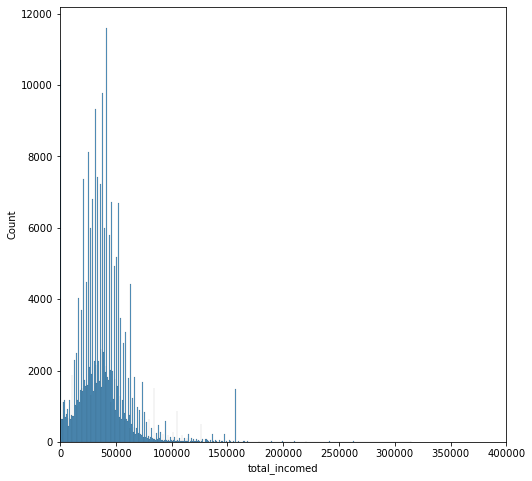

In [26]:
plot_distribution(msample, "total_incomed")
msample["total_incomed"].mean()

In [ ]:
msample['husband_distribution'].value_counts().plot(kind='bar')

In [ ]:
income_dad_density=plt.figure(figsize=(8,8))
income_dad_density=plt.xlim(0,400000)
income_dad_density=plt.xlabel('Total Income Dad')
income_dad_density=plt.ylabel('Density')
income_dad_density=sns.kdeplot(msample['total_incomed'],shade=True)
income_dad_density

In [ ]:
sample=msample[msample["husband_distribution"]=="upper_third"]
sample["workedm"].mean()

In [29]:
table1_2=table_sum_stats(msample)
table1_2

,Mean,Standard Deviation,Description
KIDCOUNT,2.51,0.77,Children ever born
more2k,0.38,0.49,More than two children
boy1st,0.51,0.50,First child was a boy
boy2nd,0.51,0.50,Second child was a boy
two_boys,0.27,0.44,First two children were boys
two_girls,0.24,0.43,First two children were girls
AGEM,30.39,3.39,Age
agefstm,21.22,2.90,Age at first birth
workedm,0.53,0.50,If worked for pay in year prior to the census
WEEKSM,19.02,21.87,Weeks worked in year prior to the census


In [ ]:
keys = ['All women, PUMS 1980', 'Married couples, PUMS 1980']
frames = [table1, table1_2]
table2 = pd.concat(frames, axis=1, keys=keys) 
table2 = table2.drop(table2.columns[[2]], axis=1) 
table2

In [ ]:
data["INCOME1D"].describe()
data["INCOME2D"].describe()
msample["qtrmar"].describe()
sum(pd.isnull(data['agefstd']))

In [ ]:
variables1=["(1) one girl", "(2) one boy", "difference (2) - (1)"]
frequencies1=['Fraction of sample', 'Fraction that had another child']

def Table_3_panel_1(data):
    Table_3_panel1 = pd.DataFrame(np.nan, index=variables1, columns=frequencies1)
    Table_3_panel1.index.name="Sex of first child in families with one or more children"
    a=pd.DataFrame(data['boy1st'].value_counts(normalize=True)*100)
    a1=a.iloc[(0,0)]
    b1=a.iloc[(1,0)]

    c=pd.DataFrame(data.groupby("boy1st")["more1k"].value_counts(normalize=True) * 100)
    c1=c.iloc[(0,0)]
    d1=c.iloc[(2,0)]
    diff1=d1-c1

    Table_3_panel1.iloc[0,0]=a1
    Table_3_panel1.iloc[1,0]=b1

    Table_3_panel1.iloc[0,1]=c1
    Table_3_panel1.iloc[1,1]=d1
    Table_3_panel1.iloc[2,1]=diff1

    return Table_3_panel1

In [ ]:
variables=["(1) one girl one boy", "(2) two boys", "(3) two girls", "(4) both same sex", "Difference (4) - (1)"]
frequencies=['Fraction of sample', 'Fraction that had another child']

def Table_3_panel_2(data):
    
    Table_3_panel2 = pd.DataFrame(np.nan, index=variables, columns=frequencies)
    Table_3_panel2.index.name="Sex of first child in families with two or more children"
    a2=pd.DataFrame(data['mixed_sex'].value_counts(normalize=True)*100)
    a2=a2.iloc[(1,0)]
    b2=pd.DataFrame(data['two_boys'].value_counts(normalize=True)*100)
    b2=b2.iloc[(1,0)]
    c2=pd.DataFrame(data['two_girls'].value_counts(normalize=True)*100)
    c2=c2.iloc[(1,0)]
    d2=pd.DataFrame(data['same_sex'].value_counts(normalize=True)*100)
    d2=d2.iloc[(0,0)]

    f2=pd.DataFrame(data.groupby("mixed_sex")["more3k"].value_counts(normalize=True) * 100)
    f2=f2.iloc[(3,0)]
    g2=pd.DataFrame(data.groupby("two_boys")["more3k"].value_counts(normalize=True) * 100)
    g2=g2.iloc[(3,0)]
    h2=pd.DataFrame(data.groupby("two_girls")["more3k"].value_counts(normalize=True) * 100)
    h2=h2.iloc[(3,0)]
    i2=pd.DataFrame(data.groupby("same_sex")["more3k"].value_counts(normalize=True) * 100)
    i2=i2.iloc[(3,0)]
    diff2=(i2-f2)/100
    #sd_diff2=np.sum(np.square(diff2))

    Table_3_panel2.iloc[0,0]=a2
    Table_3_panel2.iloc[1,0]=b2
    Table_3_panel2.iloc[2,0]=c2
    Table_3_panel2.iloc[3,0]=d2
    Table_3_panel2.iloc[4,0]="-"
    #Table_3_panel2.iloc[5,0]="-"

    Table_3_panel2.iloc[0,1]=f2
    Table_3_panel2.iloc[1,1]=g2
    Table_3_panel2.iloc[2,1]=h2
    Table_3_panel2.iloc[3,1]=i2
    Table_3_panel2.iloc[4,1]=diff2
    #Table_3_panel2.iloc[5,1]=sd_diff2

    return Table_3_panel2


In [ ]:
Table3_1_1=Table_3_panel_1(data)
Table3_1_2=Table_3_panel_1(msample_total)
Table3_2_1=Table_3_panel_2(data_2)
Table3_2_2=Table_3_panel_2(msample)

keys = ['All women, PUMS 1980', 'Married women, PUMS 1980']
frames1 = [Table3_1_1, Table3_1_2]
frames2 = [Table3_2_1, Table3_2_2]
table3_1 = pd.concat(frames1, axis=1, keys=keys) 
table3_2 = pd.concat(frames2, axis=1, keys=keys)

In [ ]:
table3_1

In [ ]:
table3_2

In [ ]:
#TABLE 6
def OLS_Regressions_more2k(data1, data2):
    
    model1_table6=sm_api.OLS(data1["more2k"], sm_api.add_constant(data1["same_sex"])).fit()
    model2_table6=sm_api.OLS(data1["more2k"], sm_api.add_constant(data1[["same_sex", "boy1st", "boy2nd"]])).fit()
    model3_table6=sm_api.OLS(data1["more2k"], sm_api.add_constant(data1[["boy1st", "two_boys", "two_girls"]])).fit()
    model4_table6=sm_api.OLS(data2["more2k"], sm_api.add_constant(data2["same_sex"])).fit()
    model5_table6=sm_api.OLS(data2["more2k"], sm_api.add_constant(data2[["same_sex", "boy1st", "boy2nd"]])).fit()
    model6_table6=sm_api.OLS(data2["more2k"], sm_api.add_constant(data2[["boy1st", "two_boys", "two_girls"]])).fit()
    Table = Stargazer([model1_table6, model2_table6, model3_table6, model4_table6, model5_table6, model6_table6])
    Table.title("Table 6 Part 1: OLS Estimates of More than 2 children equations - PUMS 1980")
    Table.custom_columns(['All women', 'All women', 'All women', 'Married women', 'Married women', 'Married women'], 
                         [1, 1, 1, 1, 1, 1])
    Table.significant_digits(4)
    #Table.custom_columns('All women')
    
    return Table

In [ ]:
OLS_Regressions_more2k(data_2, msample)

In [ ]:
def OLS_Labor_Supply_Models(data, outcomes, controls_1, controls_2, controls_3):

    table = pd.DataFrame(
        {
            "OLS (1)": [],
            "Std.err (1)": [],
            "IV-same sex (2)": [],
            "Std.err (2)": [],
            "IV-two girls, two boys (3)": [],
            "Std.err (3)": [],
        }
    )
    table["outcomes"] = outcomes
    table = table.set_index("outcomes")

    for outcome in outcomes:

        data=data
        model_OLS=sm_api.OLS(data[outcome], (data[controls_1]))
        result_OLS=model_OLS.fit()
        model_IV_1=IV2SLS(data[outcome], data[controls_2], data["more2k"], data["same_sex"])
        result_IV_1=model_IV_1.fit()
        model_IV_2=IV2SLS(data[outcome], data[controls_3], data["more2k"], data[["two_boys","two_girls"]])
        result_IV_2=model_IV_2.fit()        
        
        outputs = [
                result_OLS.params["more2k"],
                result_OLS.bse["more2k"],
                result_IV_1.params["more2k"],
                result_IV_1.std_errors["more2k"],
                result_IV_2.params["more2k"],
                result_IV_2.std_errors["more2k"],
            
        ]
        
        table.loc[outcome] = outputs
        table = table.round(3)

    return table

In [ ]:
outcomes_labor_supply_moms=["workedm", "WEEKSM", "HOURSM", "total_incomem", "faminc_log", "nonmomi_log"]
outcomes_labor_supply_dads=["workedd", "WEEKSD", "HOURSD", "total_incomed", "faminc_log", "nonmomi_log"]
controls_OLS_moms = ["const", "more2k", 'AGEM', 'agefstm', "boy1st", "boy2nd", "blackm", "hispm", "otheracem"]
controls_IV_1_moms=["const", 'AGEM', 'agefstm', "boy1st", "boy2nd", "blackm", "hispm", "otheracem"]
controls_IV_2_moms=["const", 'AGEM', 'agefstm', "boy1st", "blackm", "hispm", "otheracem"]
controls_OLS_dads = ["const", "more2k", 'AGED', 'agefstd', "boy1st", "boy2nd", "blackd", "hispd", "otheraced"]
controls_IV_1_dads=["const", 'AGED', 'agefstd', "boy1st", "boy2nd", "blackd", "hispm", "otheraced"]
controls_IV_2_dads=["const", 'AGED', 'agefstd', "boy1st", "blackd", "hispd", "otheraced"]

In [ ]:
Table7_1=OLS_Labor_Supply_Models(data_2, outcomes_labor_supply_moms, controls_OLS_moms, controls_IV_1_moms, controls_IV_2_moms)

In [ ]:
Table7_2=OLS_Labor_Supply_Models(msample, outcomes_labor_supply_moms, controls_OLS_moms, controls_IV_1_moms, controls_IV_2_moms)

In [ ]:
Table7_3=OLS_Labor_Supply_Models(msample, outcomes_labor_supply_dads, controls_OLS_dads, controls_IV_1_dads, controls_IV_2_dads)

In [ ]:
keys=["All women", "Married Women", "Husbands"]
frames=[Table7_1, Table7_2, Table7_3]
Table7=pd.concat(frames, axis=1, keys=keys)
Table7 = Table7.replace(np.nan, '-', regex=True)
Table7

In [ ]:
#from linearmodels.iv import IV2SLS
#mod = IV2SLS.from_formula('workedm ~ 1 + AGEM + agefstm + boy1st + blackm + hispm + otheracem + [more2k ~ two_boys + two_girls]', data_2)
#formula=
#mod.fit()
#res=mod.fit()
#res.params["more2k"]

#from linearmodels.iv import IV2SLS

#controls=["AGEM", 'agefstm', "boy1st", "boy2nd", "blackm", "hispm", "otheracem"]
#controls = ['const'] + controls
#modelo=IV2SLS(data_2["WEEKSM"], data_2[["const", "AGEM", 'agefstm', "boy1st", "boy2nd", "blackm", "hispm", "otheracem"]], data_2["more2k"], data_2[["same_sex", "two_girls"]]).has_constant("const")
#res=modelo.fit()[]
#res.std_errors["more2k"]
#res.bse["more2k"]


In [ ]:
#table = pd.DataFrame({
#            "formula": [], })
#table
#outcomes=["workedm", "WEEKSM", "HOURSM", "total_incomem", "faminc_log", "nonmomi_log"]
#controls_IV=["const", 'AGEM']
#instrumens=[]

#for outcome in outcomes:
#    formula=outcome + " ~  1 + " + " + ".join(controls_IV)+"[more2k ~ two_boys + two_girls]"
#    table.loc[outcome] = formula
#table

In [ ]:
#formula="workedm" + " ~  1 + " + " + ".join(controls_IV)+"[more2k ~ two_boys + two_girls]"
#mod = IV2SLS.from_formula(formula, data_2)

In [ ]:
##OLS INTERACTION TERMS WIFE EDUC
## se lee el coef de more2k
MODELO_BUENO1= smf.ols(formula='workedm ~ more2k:lessgrad + more2k + AGEM + agefstm + boy1st + boy2nd + blackm + hispm + otheracem', data=msample).fit()


MODELO_BUENO2= smf.ols(formula='workedm ~ more2k:hsgrad + more2k + AGEM + agefstm + boy1st + boy2nd + blackm + hispm + otheracem', data=msample).fit()

MODELO_BUENO3= smf.ols(formula='workedm ~ more2k:moregrad + more2k + AGEM + agefstm + boy1st + boy2nd + blackm + hispm + otheracem', data=msample).fit()


In [ ]:
# IV INTERACTION TERMS FOR WIFES
#se lee el coef de la interacción!
mod1 = IV2SLS.from_formula('workedm ~ 1 + lessgrad + AGEM + agefstm + boy1st + blackm + hispm + otheracem + [more2k:lessgrad ~ same_sex:lessgrad]', msample).fit()
mod2 = IV2SLS.from_formula('workedm ~ 1 + hsgrad + AGEM + agefstm + boy1st + blackm + hispm + otheracem + [more2k:hsgrad ~ same_sex:hsgrad]', msample).fit()
mod3 = IV2SLS.from_formula('workedm ~ 1 + moregrad + AGEM + agefstm + boy1st + blackm + hispm + otheracem + [more2k:moregrad ~ same_sex:moregrad]', msample).fit()


In [ ]:
# IV INTERACTION TERMS FOR WIFES
#se lee el coef de la interacción!
mod4 = IV2SLS.from_formula('WEEKSM ~ 1 + lessgrad + AGEM + agefstm + boy1st + blackm + hispm + otheracem + [more2k:lessgrad ~ same_sex:lessgrad]', msample).fit()
mod5 = IV2SLS.from_formula('WEEKSM ~ 1 + hsgrad + AGEM + agefstm + boy1st + blackm + hispm + otheracem + [more2k:hsgrad ~ same_sex:hsgrad]', msample).fit()
mod6 = IV2SLS.from_formula('WEEKSM ~ 1 + moregrad + AGEM + agefstm + boy1st + blackm + hispm + otheracem + [more2k:moregrad ~ same_sex:moregrad]', msample).fit()


In [ ]:
#model_OLS=sm_api.OLS(msaple["workedm"], (data["same_sex"]))
#mod = smf.ols(formula='workedm ~ more2k*moregrad + AGEM + agefstm + boy1st + boy2nd + blackm + hispm + otheracem', data=msample)

#mod1 = IV2SLS.from_formula('workedm ~ 1 + more2k:lessgrad + lessgrad + AGEM + agefstm + boy1st + blackm + hispm + otheracem + [more2k ~ same_sex]', msample).fit()
#result1=mod1.

#mod2 = IV2SLS.from_formula('workedm ~ 1 + more2k:hsgrad + hsgrad + AGEM + agefstm + boy1st + blackm + hispm + otheracem + [more2k ~ same_sex]', msample)
#result2=mod2.fit()

#mod3 = IV2SLS.from_formula('workedm ~ 1 + more2k:moregrad + moregrad + AGEM + agefstm + boy1st + blackm + hispm + otheracem + [more2k ~ same_sex]', msample)
#result3=mod3.fit()

In [ ]:
#mod4 = IV2SLS.from_formula('WEEKSM ~ 1 + more2k:lessgrad + lessgrad + AGEM + agefstm + boy1st + boy2nd + blackm + hispm + otheracem + [more2k ~ same_sex]', msample).fit()
#result4=mod4

#mod5 = IV2SLS.from_formula('WEEKSM ~ 1 + more2k:hsgrad + hsgrad + AGEM + agefstm + boy1st + boy2nd + blackm + hispm + otheracem + [more2k ~ same_sex]', msample)
#result5=mod5.fit()

#mod6 = IV2SLS.from_formula('WEEKSM ~ 1 + more2k:moregrad + moregrad + AGEM + agefstm + boy1st + boy2nd + blackm + hispm + otheracem + [more2k ~ same_sex]', msample)
#result6=mod6.fit()

In [ ]:
##OLS INTERACTION TERMS HUSBAND EARNINGS DISTRIBUTION
## se lee el coef de more2k
MODELO_BUENO4= smf.ols(formula='workedm ~ more2k:bottom_third + more2k + AGEM + agefstm + boy1st + boy2nd + blackm + hispm + otheracem', data=msample).fit()
MODELO_BUENO5= smf.ols(formula='workedm ~ more2k:middle_third + more2k + AGEM + agefstm + boy1st + boy2nd + blackm + hispm + otheracem', data=msample).fit()
MODELO_BUENO6= smf.ols(formula='workedm ~ more2k:upper_third + more2k + AGEM + agefstm + boy1st + boy2nd + blackm + hispm + otheracem', data=msample).fit()

In [ ]:
MODELO_BUENO7= smf.ols(formula='WEEKSM~ more2k:bottom_third + more2k + AGEM + agefstm + boy1st + boy2nd + blackm + hispm + otheracem', data=msample).fit()
MODELO_BUENO8= smf.ols(formula='WEEKSM ~ more2k:middle_third + more2k + AGEM + agefstm + boy1st + boy2nd + blackm + hispm + otheracem', data=msample).fit()
MODELO_BUENO9= smf.ols(formula='WEEKSM ~ more2k:upper_third + more2k + AGEM + agefstm + boy1st + boy2nd + blackm + hispm + otheracem', data=msample).fit()

In [ ]:
# IV INTERACTION TERMS FOR HUSBANDS DISTRIBUTIONS
#se lee el coef de la interacción!
mod7 = IV2SLS.from_formula('workedm ~ 1 + bottom_third + AGEM + agefstm + boy1st + blackm + hispm + otheracem + [more2k:bottom_third ~ same_sex:bottom_third]', msample).fit()
mod8 = IV2SLS.from_formula('workedm ~ 1 + middle_third + AGEM + agefstm + boy1st + blackm + hispm + otheracem + [more2k:middle_third ~ same_sex:middle_third]', msample).fit()
mod9 = IV2SLS.from_formula('workedm ~ 1 + upper_third + AGEM + agefstm + boy1st + blackm + hispm + otheracem + [more2k:upper_third ~ same_sex:upper_third]', msample).fit()


In [ ]:
mod10 = IV2SLS.from_formula('WEEKSM ~ 1 + bottom_third + AGEM + agefstm + boy1st + blackm + hispm + otheracem + [more2k:bottom_third ~ same_sex:bottom_third]', msample).fit()
mod11 = IV2SLS.from_formula('WEEKSM ~ 1 + middle_third + AGEM + agefstm + boy1st + blackm + hispm + otheracem + [more2k:middle_third ~ same_sex:middle_third]', msample).fit()
mod12 = IV2SLS.from_formula('WEEKSM ~ 1 + upper_third + AGEM + agefstm + boy1st + blackm + hispm + otheracem + [more2k:upper_third ~ same_sex:upper_third]', msample).fit()


In [ ]:
#WIFE's by WIfe education whose husbands earnings are in the middle thrird 
MODELO_BUENO_wh= smf.ols(formula='workedm ~ more2k:lessgrad + more2k + AGEM + agefstm + boy1st + boy2nd + blackm + hispm + otheracem', data=sample_middle_third).fit()

MODELO_BUENO2_wh= smf.ols(formula='workedm ~ more2k:hsgrad + more2k + AGEM + agefstm + boy1st + boy2nd + blackm + hispm + otheracem', data=sample_middle_third).fit()

MODELO_BUENO3_wh= smf.ols(formula='workedm ~ more2k:moregrad + more2k + AGEM + agefstm + boy1st + boy2nd + blackm + hispm + otheracem', data=sample_middle_third).fit()


In [112]:
#FUNCTION FOR TABLE 9

def OLS_Labor_Supply_Interactions(data, Interaction, outcome):
    
    table = pd.DataFrame(
        {
            "OLS (1)": [],
            "Std.err (1)": [],

        }
    )
    table["Interactions"] = Interaction
    table = table.set_index("Interactions")
    table

    for interaction in Interaction:

        mod=sm_api.OLS(data[outcome], data[[interaction, "more2k", "AGEM", "agefstm", "boy1st", "boy2nd", "blackm", "hispm", "otheracem"]])
        results_mod=mod.fit()


        outputs = [
                results_mod.params["more2k"],
                results_mod.bse["more2k"],
        ]

        table.loc[interaction] = outputs

    return table

In [113]:
Interaction1="more2k_bottomthird", "more2k_middlethird", "more2k_upperthird", "more2k_lessgrad", "more2k_hsgrad", "more2k_moregrad"
outcome="workedm"

Table9_1=OLS_Labor_Supply_Interactions(msample, Interaction1, outcome)
Table9_1

,OLS (1),Std.err (1)
Interactions,,
more2k_bottomthird,-0.179121,0.002362
more2k_middlethird,-0.178488,0.002318
more2k_upperthird,-0.116119,0.002356
more2k_lessgrad,-0.145462,0.002227
more2k_hsgrad,-0.158056,0.002541
more2k_moregrad,-0.174297,0.002335


In [141]:
def IV_Labor_Supply_Interactions(data, outcome):
    
    table = pd.DataFrame(
        {
            "IV (2)": [],
            "Std.err (2)": [],

        }
    )
    table["Interactions"] = ["more2k_bottomthird", "more2k_middlethird", "more2k_upperthird", "more2k_lessgrad", "more2k_hsgrad", "more2k_moregrad"]
    table = table.set_index("Interactions")
    table

    model_IV_1=IV2SLS(msample[outcome], data[["const", "bottom_third", "AGEM", "agefstm", "boy1st", "blackm", "hispm", "otheracem"]], data["more2k_bottomthird"], data["samesex_bottomthird"]).fit() 
    model_IV_2=IV2SLS(msample[outcome], data[["const", "middle_third", "AGEM", "agefstm", "boy1st", "blackm", "hispm", "otheracem"]], data["more2k_middlethird"], data["samesex_middlethird"]).fit()  
    model_IV_3=IV2SLS(msample[outcome], data[["const", "upper_third", "AGEM", "agefstm", "boy1st", "blackm", "hispm", "otheracem"]], data["more2k_upperthird"], data["samesex_upperthird"]).fit()  

    model_IV_4=IV2SLS(msample[outcome], data[["const", "lessgrad", "AGEM", "agefstm", "boy1st", "blackm", "hispm", "otheracem"]], data["more2k_lessgrad"], data["samesex_lessgrad"]).fit() 
    model_IV_5=IV2SLS(msample[outcome], data[["const", "hsgrad", "AGEM", "agefstm", "boy1st", "blackm", "hispm", "otheracem"]], data["more2k_hsgrad"], data["samesex_hsgrad"]).fit()  
    model_IV_6=IV2SLS(msample[outcome], data[["const", "moregrad", "AGEM", "agefstm", "boy1st", "blackm", "hispm", "otheracem"]], data["more2k_moregrad"], data["samesex_moregrad"]).fit() 

    outputs1 = [model_IV_1.params["more2k_bottomthird"],model_IV_1.std_errors["more2k_bottomthird"],]
    outputs2 = [model_IV_2.params["more2k_middlethird"],model_IV_2.std_errors["more2k_middlethird"],]
    outputs3 = [model_IV_3.params["more2k_upperthird"],model_IV_3.std_errors["more2k_upperthird"],]

    outputs4 = [model_IV_4.params["more2k_lessgrad"],model_IV_4.std_errors["more2k_lessgrad"],]
    outputs5 = [model_IV_5.params["more2k_hsgrad"],model_IV_5.std_errors["more2k_hsgrad"],]
    outputs6 = [model_IV_6.params["more2k_moregrad"],model_IV_6.std_errors["more2k_moregrad"],]

    table.loc["more2k_bottomthird"] = outputs1
    table.loc["more2k_middlethird"] = outputs2
    table.loc["more2k_upperthird"] = outputs3
    table.loc["more2k_lessgrad"] = outputs4
    table.loc["more2k_hsgrad"] = outputs5
    table.loc["more2k_moregrad"] = outputs6

    return table

In [143]:
Table9_2=IV_Labor_Supply_Interactions(msample, "workedm")
Table9_2

,IV (2),Std.err (2)
Interactions,,
more2k_bottomthird,-0.126124,0.064498
more2k_middlethird,-0.165977,0.046635
more2k_upperthird,-0.095888,0.041898
more2k_lessgrad,-0.121663,0.065471
more2k_hsgrad,-0.151354,0.038493
more2k_moregrad,-0.075174,0.054099


* **Angrist, J., & Evans, W. (1998)**. *Children and Their Parents' Labor Supply: Evidence from Exogenous Variation in Family Size*, 88(3), The American Economic Review.




-------
Notebook by Carolina Alvarez | GitHub profile: https://github.com/carolinalvarez.

---